In [1]:
import numpy as np
from dataclasses import asdict
import qiskit
from qiskit.circuit.library import EfficientSU2

from qiskit_ibm_runtime import QiskitRuntimeService, Options
from qiskit_ibm_runtime.options import SimulatorOptions
from quantum_serverless import QuantumServerless, get

from circuit_knitting_toolbox.circuit_cutting.wire_cutting import verify
from circuit_knitting_toolbox.circuit_cutting.wire_cutting import cut_circuit_wires
from circuit_knitting_toolbox.circuit_cutting.wire_cutting import evaluate_subcircuits
from circuit_knitting_toolbox.circuit_cutting.wire_cutting import reconstruct_full_distribution


import remote_runtime
import my_noise_models

# Qiskit Runtime on IBM Cloud
The following is based on the getting started [tutorial](https://cloud.ibm.com/docs/quantum-computing?topic=quantum-computing-get-started)

In [2]:
service = QiskitRuntimeService()
print(service.backends())
print(service.programs())

[<IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_statevector')>]
[<RuntimeProgram('qasm3-runner')>, <RuntimeProgram('hello-world-89yvgl6jG5')>, <RuntimeProgram('hello-world')>, <RuntimeProgram('sampler')>, <RuntimeProgram('estimator')>]


In [3]:
options = Options(optimization_level=3)

# Circuit construction
theta = qiskit.circuit.Parameter('theta')
phi = qiskit.circuit.Parameter('phi')

circuit = qiskit.QuantumCircuit(2, 2)
circuit.ry(theta, 0)
circuit.rz(phi, 0)
circuit.cx(0,1)
circuit.measure_all(add_bits=False)
print(circuit.draw())

params1 = [np.pi/4, 0]
params2 = [np.pi/2, np.pi/2]
params3 = [3*np.pi/4, -np.pi/3]

     ┌───────────┐┌─────────┐      ░ ┌─┐   
q_0: ┤ Ry(theta) ├┤ Rz(phi) ├──■───░─┤M├───
     └───────────┘└─────────┘┌─┴─┐ ░ └╥┘┌─┐
q_1: ────────────────────────┤ X ├─░──╫─┤M├
                             └───┘ ░  ║ └╥┘
c: 2/═════════════════════════════════╩══╩═
                                      0  1 


In [18]:
with Session(service=service, backend="simulator_statevector"):
    sampler = Sampler(options=options)
    
    job = sampler.run(circuits=[circuit]*3, parameter_values=[params1, params2, params3])
    print(job.result())

SamplerResult(quasi_dists=[{0: 1.0}, {3: 0.49325, 0: 0.50675}, {3: 0.2525, 0: 0.7475}], metadata=[{'header_metadata': {}, 'shots': 4000}, {'header_metadata': {}, 'shots': 4000}, {'header_metadata': {}, 'shots': 4000}])


# Running a Quantum Serverless program on a Cloud Runtime backend

## Circuit cutting with quantum serverless
An example [tutorial](https://qiskit-extensions.github.io/circuit-knitting-toolbox/tutorials/circuit_cutting/tutorial_3_cutting_with_quantum_serverless.html) combines the circuit cutting
package with quantum serverless.

In [2]:
num_qubits = 4
#circuit = EfficientSU2(num_qubits=num_qubits, reps=2, entanglement="linear", su2_gates=["ry"])
#circuit = circuit.decompose()
#params = [(np.pi * i) / 16 for i in range(len(circuit.parameters))]
#circuit = circuit.bind_parameters(params)

circuit = qiskit.QuantumCircuit(num_qubits)
circuit.h(0)
for i in range(num_qubits-1):
    circuit.cx(i, i+1)

circuit.draw(fold=-1)

┌───┐               
q_0: ┤ H ├──■────────────
     └───┘┌─┴─┐          
q_1: ─────┤ X ├──■───────
          └───┘┌─┴─┐     
q_2: ──────────┤ X ├──■──
               └───┘┌─┴─┐
q_3: ───────────────┤ X ├
                    └───┘

In [3]:
serverless = QuantumServerless()
serverless.providers()

[<Provider: local>]

In [5]:
cuts = cut_circuit_wires(
    circuit=circuit,
    method="automatic",
    max_subcircuit_width=3,
    max_cuts=1,
    num_subcircuits=[2],
)

Exporting as a LP file to let you check the model that will be solved :  inf <class 'float'>
Version identifier: 22.1.0.0 | 2022-03-27 | 54982fbec
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               300
Tried aggregator 4 times.
MIP Presolve eliminated 39 rows and 11 columns.
MIP Presolve modified 13 coefficients.
Aggregator did 25 substitutions.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.20 ticks)

Root node processing (before b&c):
  Real time             =    0.00 sec. (0.20 ticks)
Parallel b&c, 10 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.00 sec. (0.20 ticks)
--------------------
subcircuit 0
ρ qubits = 0, O qubits = 1, width = 2, effective = 1, depth = 2, size = 2
     ┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘
subcircu

In [11]:
with serverless.context():
    cuts_future = remote_runtime.cut_circuit_wires_remote(
        circuit=circuit,
        method="automatic",
        max_subcircuit_width=3,
        max_cuts=1,
        num_subcircuits=[2],
    )
    
    cuts = get(cuts_future)

In [6]:
cuts["subcircuits"][0].draw(fold=-1, scale=0.6)

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

In [7]:
cuts["subcircuits"][1].draw(fold=-1)

q_0: ──■───────
     ┌─┴─┐     
q_1: ┤ X ├──■──
     └───┘┌─┴─┐
q_2: ─────┤ X ├
          └───┘

In [8]:
service = QiskitRuntimeService()
print(service.backends())
print(service.programs())

[<IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_statevector')>]
[<RuntimeProgram('qasm3-runner')>, <RuntimeProgram('hello-world-89yvgl6jG5')>, <RuntimeProgram('hello-world')>, <RuntimeProgram('sampler')>, <RuntimeProgram('estimator')>]


In [9]:
options = Options(execution={"shots":4000})

backend_names = ["ibmq_qasm_simulator"] * 2

In [10]:
service.get_backend("ibmq_qasm_simulator")

<IBMBackend('ibmq_qasm_simulator')>

In [11]:
subcircuit_instance_probabilities = evaluate_subcircuits(
    cuts,
    service=service,
    backend_names=backend_names,
    options=options,
)

In [ ]:
with serverless.context():
    service_args = service.active_account()
    
    options_dict = asdict(options)
    
    subcircuit_probabilities_future = remote_runtime.evaluate_subcircuits_remote(
        cuts,
        service_args=service_args,
        backend_names=backend_names,
        options_dict=options_dict,
    )
    
    subcircuit_instance_probabilities = get(subcircuit_probabilities_future)

In [23]:
with serverless.context():
    service_args = service.active_account()
    
    options_dict = asdict(options)
    
    subcircuit_probabilities_future = remote_runtime.evaluate_subcircuits_remote(
        cuts,
        service_args=service_args,
        backend_names=backend_names,
        options_dict=options_dict,
    )
    
    subcircuit_instance_probabilities = get(subcircuit_probabilities_future)

In [13]:
subcircuit_instance_probabilities

{0: {0: array([0.5045, 0.4955]),
  3: array([ 0.5045, -0.4955]),
  1: array([-0.00225, -0.00575]),
  2: array([-0.00925,  0.01175])},
 1: {0: array([1., 0., 0., 0., 0., 0., 0., 0.]),
  1: array([0., 0., 0., 0., 0., 0., 0., 1.]),
  2: array([0.4965, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.5035]),
  3: array([0.501, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.499])}}

In [14]:
reconstructed_probabilities = reconstruct_full_distribution(
    circuit,
    subcircuit_instance_probabilities,
    cuts,
    num_threads=2
)

In [25]:
with serverless.context():
    reconstructed_probabilities_future = remote_runtime.reconstruct_full_distribution_remote(
        circuit,
        subcircuit_instance_probabilities,
        cuts,
    )
    
    reconstructed_probabilities = get(reconstructed_probabilities_future)

(reconstruct_full_distribution_remote pid=41639) Exception ignored in: <module 'threading' from '/usr/local/Cellar/python@3.10/3.10.9/Frameworks/Python.framework/Versions/3.10/lib/python3.10/threading.py'>
(reconstruct_full_distribution_remote pid=41639) Traceback (most recent call last):
(reconstruct_full_distribution_remote pid=41639)   File "/usr/local/Cellar/python@3.10/3.10.9/Frameworks/Python.framework/Versions/3.10/lib/python3.10/threading.py", line 1518, in _shutdown
(reconstruct_full_distribution_remote pid=41639)     def _shutdown():
(reconstruct_full_distribution_remote pid=41639)   File "/Users/teague/Workspace/python-environments/runtime-env/lib/python3.10/site-packages/ray/_private/worker.py", line 1655, in sigterm_handler
(reconstruct_full_distribution_remote pid=41639)     sys.exit(signum)
(reconstruct_full_distribution_remote pid=41639) SystemExit: 15


In [15]:
reconstructed_probabilities

array([5.04498625e-01, 3.18750000e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.37500000e-06, 4.95468125e-01])

In [16]:
metrics, exact_probabilities = verify(circuit, reconstructed_probabilities)

In [17]:
metrics

{'nearest': {'chi2': 7.402838301942975e-05,
  'Mean Squared Error': 2.5485334882810605e-06,
  'Mean Absolute Percentage Error': 2078125000002.6252,
  'Cross Entropy': 0.6932212104524438,
  'HOP': 0.9999667499999998},
 'naive': {'chi2': 7.402838301943025e-05,
  'Mean Squared Error': 2.548533488281092e-06,
  'Mean Absolute Percentage Error': 2078125000002.6252,
  'Cross Entropy': 0.6932212104524436,
  'HOP': 0.99996675}}

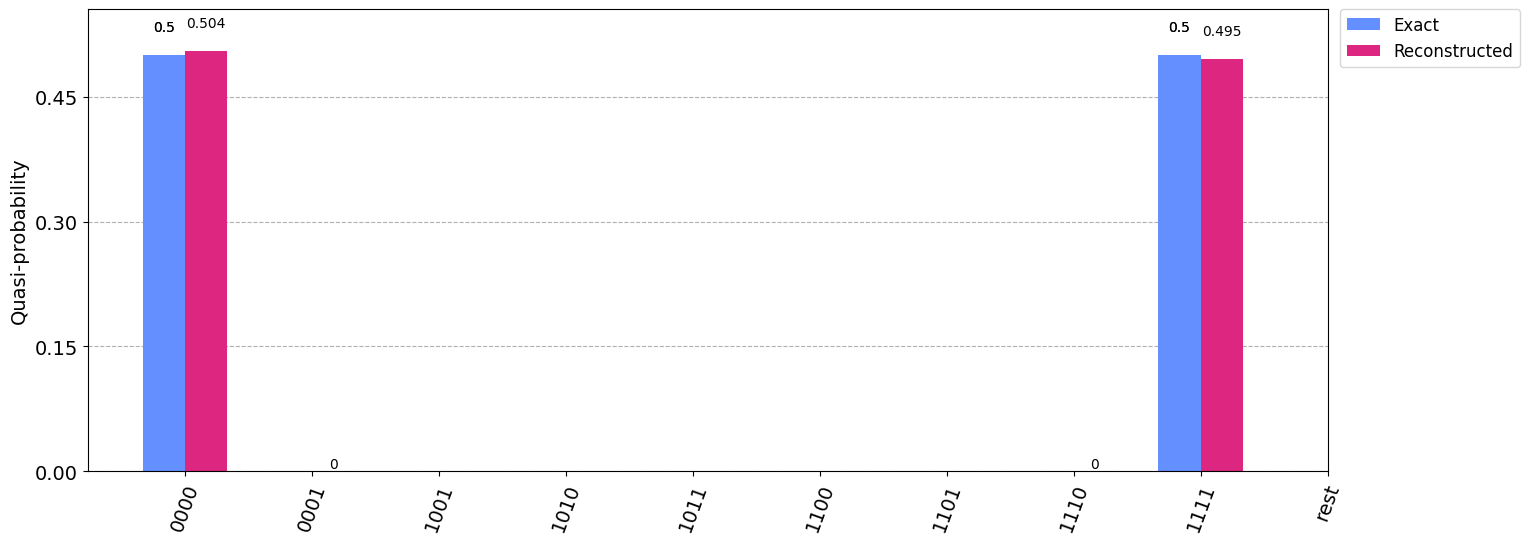

In [18]:
# Create a dict for the reconstructed distribution
reconstructed_distribution = {
    i: prob for i, prob in enumerate(reconstructed_probabilities)
}

# Represent states as bitstrings (instead of ints)

reconstructed_dict_bitstring = qiskit.result.ProbDistribution(
    data=reconstructed_distribution
).binary_probabilities(num_bits=num_qubits)


# Create the ground truth distribution dict
exact_distribution = {i: prob for i, prob in enumerate(exact_probabilities)}

# Represent states as bitstrings (instead of ints)
exact_dict_bitstring = qiskit.result.ProbDistribution(data=exact_distribution).binary_probabilities(
    num_bits=num_qubits
)

# plot a histogram of the distributions
qiskit.visualization.plot_histogram(
    [exact_dict_bitstring, reconstructed_dict_bitstring],
    number_to_keep=8,
    figsize=(16, 6),
    sort="asc",
    legend=["Exact", "Reconstructed"],
)

## Noisy simulation

In [28]:
sim_options = SimulatorOptions(
    noise_model=my_noise_models.get_pauli_noise_func(p_Xerr=0.01, p_Zerr=0.01, p_Yerr=0.01),
    basis_gates=['u1', 'u2', 'u3', 'cx'],
)

In [29]:
options = Options(execution={"shots":4000}, simulator=sim_options)

backend_names = ["ibmq_qasm_simulator"] * 2

In [30]:
subcircuit_instance_probabilities = evaluate_subcircuits(
    cuts,
    service=service,
    backend_names=backend_names,
    options=options,
)

In [25]:
with serverless.context():
    service_args = service.active_account()
    
    options_dict = asdict(options)
    
    subcircuit_probabilities_future = evaluate_subcircuits_remote(
        cuts,
        service_args=service_args,
        backend_names=backend_names,
        options_dict=options_dict,
    )
    
    subcircuit_instance_probabilities = get(subcircuit_probabilities_future)

In [31]:
subcircuit_instance_probabilities

{0: {0: array([0.51, 0.49]),
  3: array([ 0.4685, -0.458 ]),
  1: array([0.0295, 0.007 ]),
  2: array([ 0.00375, -0.01725])},
 1: {0: array([9.210e-01, 1.650e-02, 1.750e-02, 2.500e-04, 2.275e-02, 5.000e-04,
         2.125e-02, 2.500e-04]),
  1: array([2.075e-02, 1.525e-02, 5.000e-04, 1.950e-02, 2.500e-04, 1.575e-02,
         1.550e-02, 9.125e-01]),
  2: array([0.472  , 0.01775, 0.01075, 0.01   , 0.00925, 0.01025, 0.018  ,
         0.452  ]),
  3: array([0.445  , 0.0215 , 0.011  , 0.0095 , 0.01075, 0.0105 , 0.019  ,
         0.47275])}}

In [32]:
reconstructed_probabilities = reconstruct_full_distribution(
    circuit,
    subcircuit_instance_probabilities,
    cuts,
    num_threads=2
)

In [48]:
with serverless.context():
    reconstructed_probabilities_future = reconstruct_full_distribution_remote(
        circuit,
        subcircuit_instance_probabilities,
        cuts,
    )
    
    reconstructed_probabilities = get(reconstructed_probabilities_future)

(reconstruct_full_distribution_remote pid=42951) Exception ignored in: <module 'threading' from '/usr/local/Cellar/python@3.10/3.10.9/Frameworks/Python.framework/Versions/3.10/lib/python3.10/threading.py'>
(reconstruct_full_distribution_remote pid=42951) Traceback (most recent call last):
(reconstruct_full_distribution_remote pid=42951)   File "/usr/local/Cellar/python@3.10/3.10.9/Frameworks/Python.framework/Versions/3.10/lib/python3.10/threading.py", line 1518, in _shutdown
(reconstruct_full_distribution_remote pid=42951)     def _shutdown():
(reconstruct_full_distribution_remote pid=42951)   File "/Users/teague/Workspace/python-environments/runtime-env/lib/python3.10/site-packages/ray/_private/worker.py", line 1655, in sigterm_handler
(reconstruct_full_distribution_remote pid=42951)     sys.exit(signum)
(reconstruct_full_distribution_remote pid=42951) SystemExit: 15


In [33]:
subcircuit_instance_probabilities

{0: {0: array([0.51, 0.49]),
  3: array([ 0.4685, -0.458 ]),
  1: array([0.0295, 0.007 ]),
  2: array([ 0.00375, -0.01725])},
 1: {0: array([9.210e-01, 1.650e-02, 1.750e-02, 2.500e-04, 2.275e-02, 5.000e-04,
         2.125e-02, 2.500e-04]),
  1: array([2.075e-02, 1.525e-02, 5.000e-04, 1.950e-02, 2.500e-04, 1.575e-02,
         1.550e-02, 9.125e-01]),
  2: array([0.472  , 0.01775, 0.01075, 0.01   , 0.00925, 0.01025, 0.018  ,
         0.452  ]),
  3: array([0.445  , 0.0215 , 0.011  , 0.0095 , 0.01075, 0.0105 , 0.019  ,
         0.47275])}}

In [34]:
metrics, exact_probabilities = verify(circuit, reconstructed_probabilities)

In [35]:
metrics

{'nearest': {'chi2': 0.12427521040243732,
  'Mean Squared Error': 0.0005390787205075682,
  'Mean Absolute Percentage Error': 7301132812500002.0,
  'Cross Entropy': 0.8175967161227069,
  'HOP': 0.883181875},
 'naive': {'chi2': 0.12427521040243732,
  'Mean Squared Error': 0.0005390787205075682,
  'Mean Absolute Percentage Error': 7301132812500002.0,
  'Cross Entropy': 0.8175967161227069,
  'HOP': 0.883181875}}

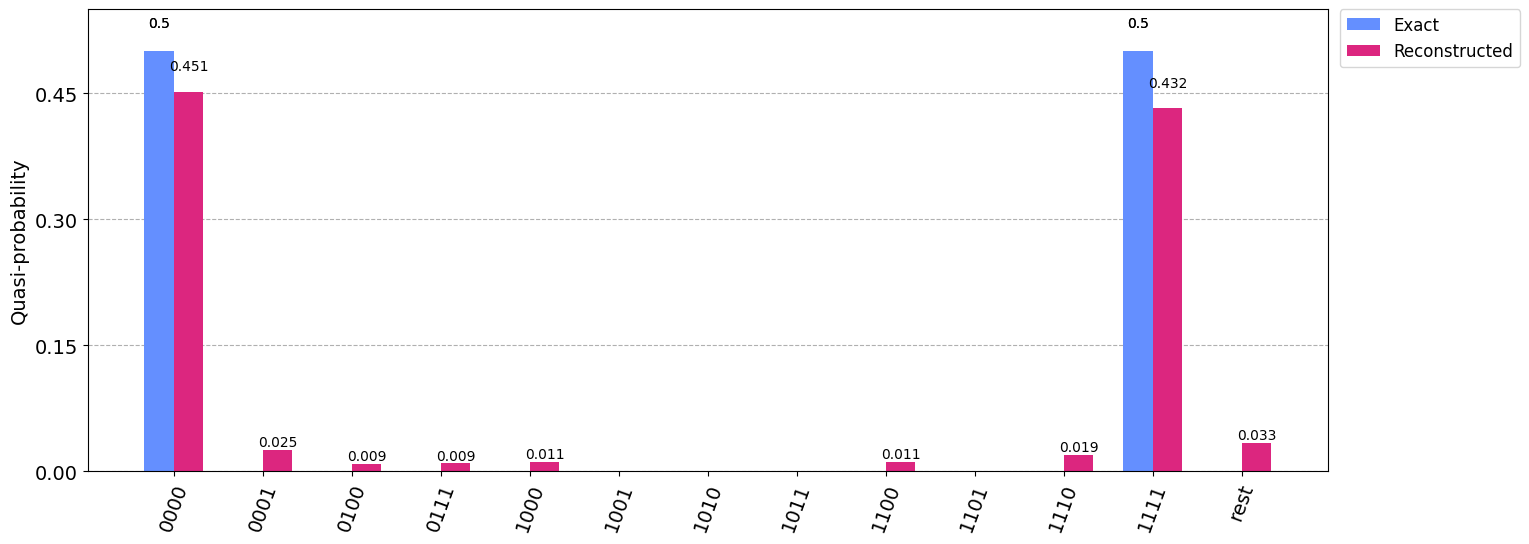

In [36]:
# Create a dict for the reconstructed distribution
reconstructed_distribution = {
    i: prob for i, prob in enumerate(reconstructed_probabilities)
}

# Represent states as bitstrings (instead of ints)

reconstructed_dict_bitstring = qiskit.result.ProbDistribution(
    data=reconstructed_distribution
).binary_probabilities(num_bits=num_qubits)


# Create the ground truth distribution dict
exact_distribution = {i: prob for i, prob in enumerate(exact_probabilities)}

# Represent states as bitstrings (instead of ints)
exact_dict_bitstring = qiskit.result.ProbDistribution(data=exact_distribution).binary_probabilities(
    num_bits=num_qubits
)

# plot a histogram of the distributions
qiskit.visualization.plot_histogram(
    [exact_dict_bitstring, reconstructed_dict_bitstring],
    number_to_keep=8,
    figsize=(16, 6),
    sort="asc",
    legend=["Exact", "Reconstructed"],
)